In [7]:
import pandas as pd

data = pd.read_csv("../data/quotes_ETH.csv")

# Calculate moving averages for price (7-day, 30-day)
data['price_ma_7d'] = data['price'].rolling(window=7).mean()
data['price_ma_30d'] = data['price'].rolling(window=30).mean()

# Compute rolling standard deviations for percentage changes
data['volatility_1h'] = data['percent_change_1h'].rolling(window=7).std()
data['volatility_24h'] = data['percent_change_24h'].rolling(window=7).std()
data['volatility_7d'] = data['percent_change_7d'].rolling(window=7).std()

# Price-to-volume ratio
data['price_to_volume'] = data['price'] / data['volume_24h']

# Momentum features
data['momentum_1h'] = data['percent_change_1h'].diff()
data['momentum_24h'] = data['percent_change_24h'].diff()
data['momentum_7d'] = data['percent_change_7d'].diff()

data.head(10)

,Unnamed: 0,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,price,volume_24h,market_cap,total_supply,circulating_supply,timestamp,price_ma_7d,price_ma_30d,volatility_1h,volatility_24h,volatility_7d,price_to_volume,momentum_1h,momentum_24h,momentum_7d
0,0,-0.867704,2.155139,-1.989964,-12.487889,2333.634858,1.558047e+10,2.808332e+11,1.203415e+08,1.203415e+08,2024-09-17T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,1.497795e-07,NaN,NaN,NaN
1,1,-0.997112,-0.807570,-0.941806,-11.133973,2314.789132,1.720900e+10,2.785693e+11,1.203433e+08,1.203433e+08,2024-09-18T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,1.345104e-07,-0.129408,-2.962708,1.048158
2,2,-0.335070,6.713400,4.890830,-5.220049,2470.190192,1.929144e+10,2.972752e+11,1.203451e+08,1.203451e+08,2024-09-19T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,1.280459e-07,0.662042,7.520970,5.832636
3,3,0.105515,2.951267,5.023355,-3.794372,2543.092093,1.962865e+10,3.060508e+11,1.203459e+08,1.203459e+08,2024-09-20T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,1.295602e-07,0.440585,-3.762134,0.132525
4,4,0.019809,1.108439,6.706664,-1.475632,2571.280728,1.043495e+10,3.094459e+11,1.203470e+08,1.203470e+08,2024-09-21T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,2.464105e-07,-0.085706,-1.842827,1.683309
5,5,-0.279656,0.121911,8.388158,-6.265828,2574.415405,1.209269e+10,3.098261e+11,1.203481e+08,1.203481e+08,2024-09-22T19:50:00.000Z,NaN,NaN,NaN,NaN,NaN,2.128902e-07,-0.299464,-0.986528,1.681494
6,6,-0.248286,4.150505,17.372761,-4.087803,2681.266640,2.065218e+10,3.226897e+11,1.203497e+08,1.203497e+08,2024-09-23T19:50:00.000Z,2498.381293,NaN,0.416977,2.554610,6.439794,1.298297e-07,0.031369,4.028594,8.984603
7,7,0.347644,-1.335220,13.362458,-4.405311,2645.465838,1.618366e+10,3.184141e+11,1.203622e+08,1.203622e+08,2024-09-24T19:50:00.000Z,2542.928575,NaN,0.428924,2.912672,6.009802,1.634652e-07,0.595930,-5.485725,-4.010303
8,8,-0.165191,-2.616387,11.295245,-4.033416,2576.250226,1.476255e+10,3.100837e+11,1.203624e+08,1.203624e+08,2024-09-25T19:50:00.000Z,2580.280160,NaN,0.247573,3.247975,4.661974,1.745125e-07,-0.512835,-1.281167,-2.067214
9,9,0.447822,2.979921,7.401465,2.519738,2653.020459,1.719155e+10,3.193249e+11,1.203628e+08,1.203628e+08,2024-09-26T19:50:00.000Z,2606.398770,NaN,0.286550,2.481564,4.325813,1.543212e-07,0.613014,5.596308,-3.893779


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define the target variable (predict the next day's price)
data['target_price'] = data['price'].shift(-1)

# Drop rows with NaN values (due to shifts and rolling computations)
data_cleaned = data.drop(columns=['Unnamed: 0']).dropna()

# Feature selection (exclude the target and irrelevant columns)
features = data_cleaned.drop(columns=['price', 'target_price', 'timestamp', 'market_cap'])

# Define X (features) and y (target)
split_time = int(len(data_cleaned) * 0.8)
X = features[:split_time].values
y = data_cleaned['target_price'][:split_time].values
X_valid = features[split_time:].values
y_valid = data_cleaned['target_price'][split_time:].values
time_valid = data_cleaned['timestamp'].apply(lambda x: x[:10])[split_time:]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, r2

(97.03816822430338, 12601.78461626671, 0.9510282458554228)

In [15]:
# validation
predictions = model.predict(X_valid_scaled)

mae = mean_absolute_error(y_valid, predictions)
mse = mean_squared_error(y_valid, predictions)
r2 = r2_score(y_valid, predictions)

mae, mse, r2

(160.78184494235666, 41056.24235982481, 0.42854364893067876)

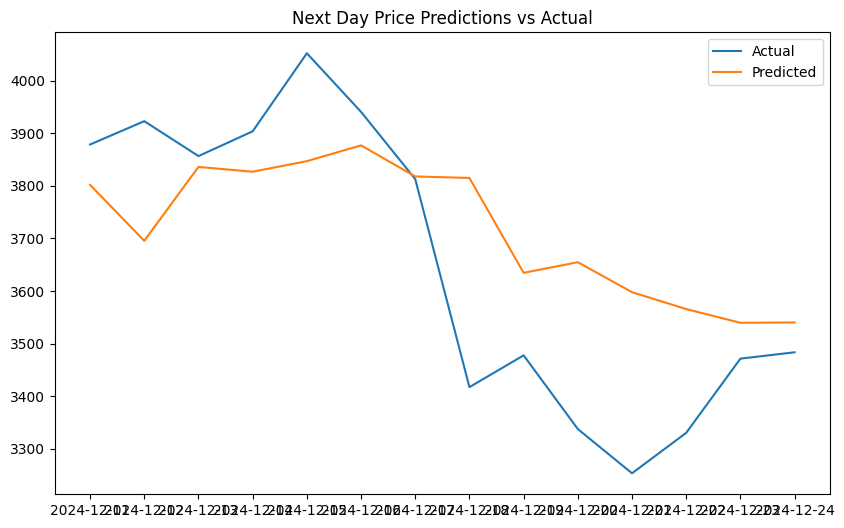

In [14]:
import matplotlib.pyplot as plt

predictions = model.predict(X_valid_scaled)

plt.figure(figsize=(10, 6))

plt.plot(time_valid, y_valid, label="Actual")
plt.plot(time_valid, predictions, label="Predicted")
plt.legend()
plt.title("Next Day Price Predictions vs Actual")
plt.show()

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train_scaled, y_train)
gbr_pred = gbr_model.predict(X_test_scaled)

gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)

gbr_mae, gbr_mse, gbr_r2

(111.85623803363087, 16476.46089458421, 0.9359708789927439)

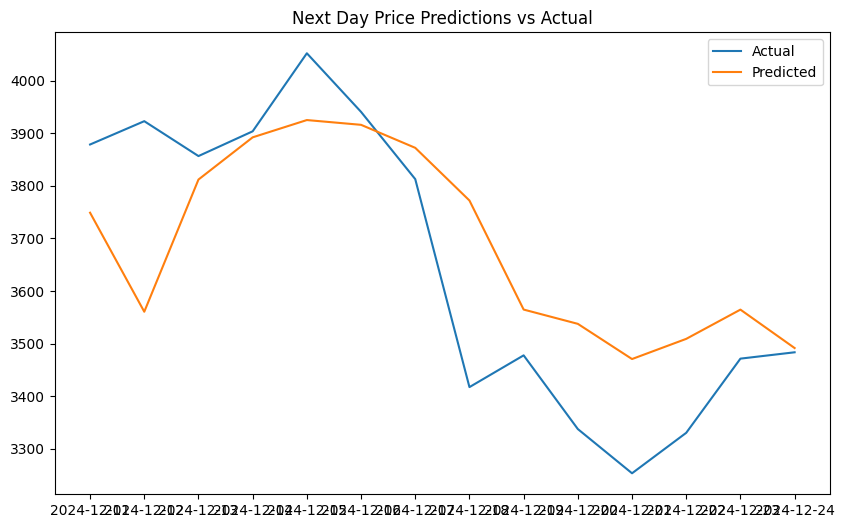

In [19]:
import matplotlib.pyplot as plt

gbr_predictions = gbr_model.predict(X_valid_scaled)

plt.figure(figsize=(10, 6))

plt.plot(time_valid, y_valid, label="Actual")
plt.plot(time_valid, gbr_predictions, label="Predicted")
plt.legend()
plt.title("Next Day Price Predictions vs Actual")
plt.show()